Database tables: ['index_definitions', 'spread_data', 'sqlite_sequence', 'curves', 'positions', 'strategies', 'pnl_history', 'raw_historical_spreads']
Retrieved 505 data points
Date range: 2023-01-03 00:00:00 to 2024-12-31 00:00:00
Long Total Return: 1.30%
Short Total Return: -1.38%
Series rolls detected: 5
Long/Short correlation: nan


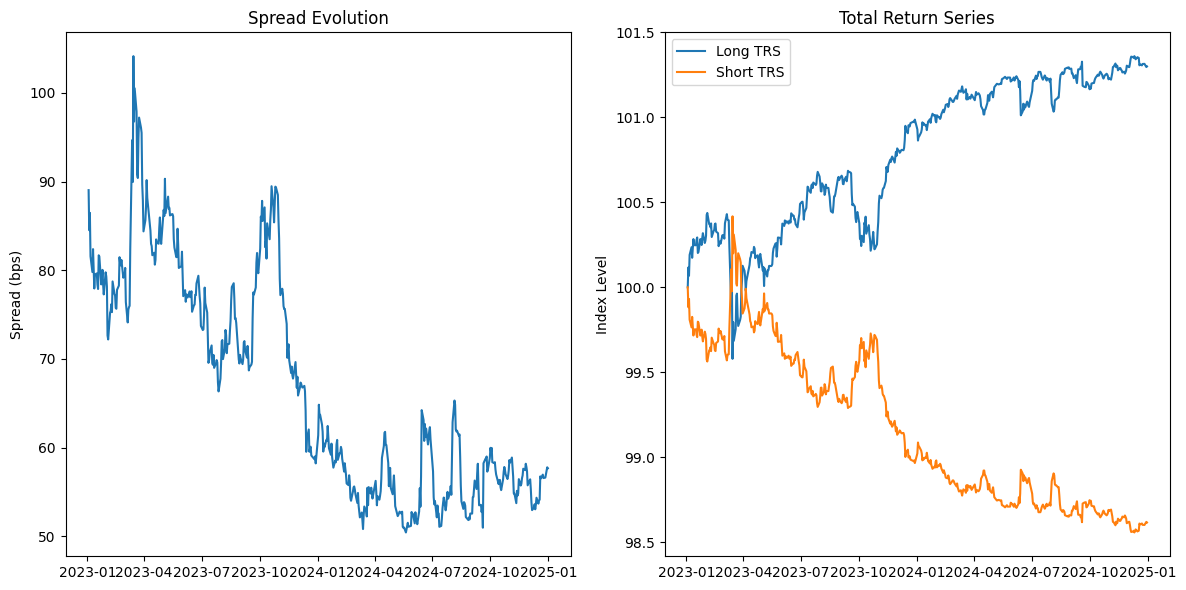

US_HY 5Y: Long +4.14%, Short -7.67%
EU_XO 5Y: Long +4.04%, Short -7.11%
US_IG 5Y: Long +0.56%, Short -0.63%
TRS calculation test complete


In [1]:
# Clean CDS Total Return Series Calculator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys
sys.path.append('../src')
from models.database import CDSDatabase

def calculate_cds_total_return(spread_data: pd.DataFrame, 
                              notional: float = 10_000_000,
                              recovery_rate: float = 0.40) -> pd.DataFrame:
    """
    Calculate CDS Total Return Series for both long and short positions
    
    Args:
        spread_data: DataFrame with columns ['date', 'spread_bps', 'series_number']
        notional: Notional amount (default $10MM)
        recovery_rate: Recovery rate assumption for DV01 calculation
        
    Returns:
        DataFrame with long_tr and short_tr columns
    """
    
    if spread_data.empty:
        return pd.DataFrame()
    
    df = spread_data.copy().sort_values('date').reset_index(drop=True)
    
    # Calculate approximate DV01 for 5Y CDS
    years_to_maturity = 5.0
    df['dv01_approx'] = (1 - recovery_rate) * df['spread_bps'] * years_to_maturity * notional / 10000
    
    # Calculate daily changes
    df['spread_change'] = df['spread_bps'].diff()
    df['daily_carry'] = df['spread_bps'] / 360
    
    # Mark-to-market P&L
    df['mtm_pnl_long'] = -df['spread_change'] * df['dv01_approx'] / 100
    df['mtm_pnl_short'] = df['spread_change'] * df['dv01_approx'] / 100
    
    # Roll adjustments
    df['is_roll_date'] = df['series_number'] != df['series_number'].shift(1)
    df['roll_cost'] = 0.0
    
    roll_dates = df[df['is_roll_date'] & (df.index > 0)]
    for idx in roll_dates.index:
        if idx > 0:
            spread_jump = df.loc[idx, 'spread_bps'] - df.loc[idx-1, 'spread_bps']
            transaction_cost = 0.1
            df.loc[idx, 'roll_cost'] = (transaction_cost + abs(spread_jump) * 0.1) * df.loc[idx, 'dv01_approx'] / 100
    
    # Total daily P&L
    df['long_daily_pnl'] = (df['daily_carry'] * notional / 10000) + df['mtm_pnl_long'] - df['roll_cost']
    df['short_daily_pnl'] = -(df['daily_carry'] * notional / 10000) + df['mtm_pnl_short'] - df['roll_cost']
    
    # Daily returns
    df['long_daily_return'] = df['long_daily_pnl'] / notional
    df['short_daily_return'] = df['short_daily_pnl'] / notional
    
    # Cumulative total return indices (starting at 100)
    df['long_tr'] = 100.0
    df['short_tr'] = 100.0
    
    for i in range(1, len(df)):
        df.loc[i, 'long_tr'] = df.loc[i-1, 'long_tr'] * (1 + df.loc[i, 'long_daily_return'])
        df.loc[i, 'short_tr'] = df.loc[i-1, 'short_tr'] * (1 + df.loc[i, 'short_daily_return'])
    
    return df

def test_trs_calculation():
    """Test TRS calculation on database data"""
    
    # Use correct database path
    db_path = "C:/source/repos/psc/packages/psc_csa_tools/credit_macro/data/raw/cds_indices_raw.db"
    db = CDSDatabase(db_path)
    
    # Check database structure
    tables = db.conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    print(f"Database tables: {[t[0] for t in tables]}")
    
    if 'raw_historical_spreads' not in [t[0] for t in tables]:
        print("ERROR: raw_historical_spreads table not found")
        db.close()
        return None
    
    # Get test data
    test_data = db.query_historical_spreads('EU_IG', '5Y', '2023-01-01', '2024-12-31')
    
    if test_data.empty:
        print("No test data found")
        db.close()
        return None
    
    print(f"Retrieved {len(test_data)} data points")
    print(f"Date range: {test_data['date'].min()} to {test_data['date'].max()}")
    
    # Calculate TRS
    trs_data = calculate_cds_total_return(test_data)
    
    if trs_data.empty:
        print("TRS calculation failed")
        db.close()
        return None
    
    # Summary results
    long_total_return = (trs_data['long_tr'].iloc[-1] / trs_data['long_tr'].iloc[0] - 1) * 100
    short_total_return = (trs_data['short_tr'].iloc[-1] / trs_data['short_tr'].iloc[0] - 1) * 100
    roll_count = trs_data['is_roll_date'].sum()
    
    print(f"Long Total Return: {long_total_return:.2f}%")
    print(f"Short Total Return: {short_total_return:.2f}%") 
    print(f"Series rolls detected: {roll_count}")
    
    # Basic validation
    correlation = np.corrcoef(trs_data['long_daily_return'], trs_data['short_daily_return'])[0,1]
    print(f"Long/Short correlation: {correlation:.3f}")
    
    # Simple plot
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(trs_data['date'], trs_data['spread_bps'])
    plt.title('Spread Evolution')
    plt.ylabel('Spread (bps)')
    
    plt.subplot(1, 2, 2) 
    plt.plot(trs_data['date'], trs_data['long_tr'], label='Long TRS')
    plt.plot(trs_data['date'], trs_data['short_tr'], label='Short TRS')
    plt.title('Total Return Series')
    plt.ylabel('Index Level')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    db.close()
    return trs_data

def test_multiple_indices():
    """Test across multiple indices"""
    
    db_path = "C:/source/repos/psc/packages/psc_csa_tools/credit_macro/data/raw/cds_indices_raw.db"
    db = CDSDatabase(db_path)
    
    test_cases = [('US_HY', '5Y'), ('EU_XO', '5Y'), ('US_IG', '5Y')]
    results = {}
    
    for index_name, tenor in test_cases:
        data = db.query_historical_spreads(index_name, tenor, '2024-01-01')
        
        if not data.empty:
            trs = calculate_cds_total_return(data)
            if not trs.empty:
                long_ret = (trs['long_tr'].iloc[-1] / trs['long_tr'].iloc[0] - 1) * 100
                short_ret = (trs['short_tr'].iloc[-1] / trs['short_tr'].iloc[0] - 1) * 100
                results[f"{index_name}_{tenor}"] = {
                    'long_return': long_ret,
                    'short_return': short_ret,
                    'data_points': len(trs)
                }
                print(f"{index_name} {tenor}: Long {long_ret:+.2f}%, Short {short_ret:+.2f}%")
    
    db.close()
    return results

# Run tests
if __name__ == "__main__":
    main_result = test_trs_calculation()
    multi_results = test_multiple_indices()
    
    print("TRS calculation test complete")

In [2]:
# Corrected CDS Relative Value Strategy Calculator
# Proper implementation of all 4 sizing methods

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def interpolate_curve_rolldown(curve_spreads: dict, current_tenor: str, months: int) -> float:
    """
    Calculate rolldown by interpolating curve
    
    Args:
        curve_spreads: Dict with tenor keys ('1Y', '3Y', '5Y', '7Y', '10Y') and spread values
        current_tenor: Current position tenor (e.g., '5Y')
        months: Number of months to roll down
        
    Returns:
        Rolldown in bps (positive = beneficial rolldown)
    """
    
    # Convert tenor to years
    tenor_map = {'1Y': 1, '3Y': 3, '5Y': 5, '7Y': 7, '10Y': 10}
    current_years = tenor_map.get(current_tenor, 5)
    target_years = current_years - (months / 12)
    
    if target_years <= 0:
        return 0.0
    
    # Get available tenors and spreads for interpolation
    available_years = []
    available_spreads = []
    
    for tenor, years in tenor_map.items():
        if tenor in curve_spreads and not pd.isna(curve_spreads[tenor]):
            available_years.append(years)
            available_spreads.append(curve_spreads[tenor])
    
    if len(available_years) < 2:
        return 0.0
    
    # Linear interpolation
    target_spread = np.interp(target_years, available_years, available_spreads)
    current_spread = curve_spreads.get(current_tenor, 0)
    
    # Rolldown = current_spread - interpolated_spread (positive = tightening = gain for long)
    rolldown = current_spread - target_spread
    
    return rolldown

def calculate_corrected_strategy_metrics(long_data: pd.DataFrame, short_data: pd.DataFrame, 
                                       long_notional: float = 10_000_000,
                                       connector=None) -> dict:
    """
    Calculate relative value strategy metrics with corrected methods
    
    Args:
        long_data: EU_XO TRS data
        short_data: EU_IG TRS data  
        long_notional: Fixed notional for long leg
        connector: Bloomberg connector for real DV01 and curve data
        
    Returns:
        Dictionary with corrected sizing recommendations
    """
    
    # Merge data on common dates
    merged = pd.merge(long_data[['date', 'spread_bps']], 
                     short_data[['date', 'spread_bps']], 
                     on='date', suffixes=('_xo', '_ig'))
    
    if merged.empty:
        return {"error": "No overlapping dates"}
    
    # Current market data
    current = merged.iloc[-1]
    xo_spread = current['spread_bps_xo']
    ig_spread = current['spread_bps_ig']
    
    # Calculate historical beta - CORRECTED
    merged['xo_change'] = merged['spread_bps_xo'].diff()
    merged['ig_change'] = merged['spread_bps_ig'].diff()
    
    valid_data = merged.dropna()
    if len(valid_data) > 30:
        # Correct regression: XO_change = alpha + beta * IG_change
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            valid_data['ig_change'], valid_data['xo_change'])
        beta = slope
        correlation = r_value
    else:
        beta = 4.0  # Assume XO moves 4x IG if insufficient data
        correlation = 0.9
    
    # Get real Bloomberg DV01 data if connector available
    if connector:
        try:
            xo_dv01 = connector.get_dv01("ITXEX543 Curncy")  # EU_XO 5Y
            ig_dv01 = connector.get_dv01("ITXEB543 Curncy")  # EU_IG 5Y
            
            # Get curve data for rolldown calculation
            xo_curve_data = connector.get_curve_data("ITRX EUR XOVER", series=43)
            ig_curve_data = connector.get_curve_data("ITRX EUR CDSI", series=43)
            
            # Calculate rolldown (3-month example)
            xo_rolldown = interpolate_curve_rolldown(xo_curve_data, "5Y", 3)
            ig_rolldown = interpolate_curve_rolldown(ig_curve_data, "5Y", 3)
            
        except Exception as e:
            print(f"Bloomberg data unavailable: {e}")
            # Use reasonable defaults for 5Y CDS
            xo_dv01 = 50000  # ~$50K per bp for 5Y CDS
            ig_dv01 = 48000  # Slightly lower for IG vs XO
            xo_rolldown = 2.0  # 2bp rolldown estimate
            ig_rolldown = 1.0  # 1bp rolldown estimate
    else:
        # Use reasonable defaults without connector
        xo_dv01 = 50000  # ~$50K per bp for 5Y CDS
        ig_dv01 = 48000  # Slightly lower for IG vs XO
        xo_rolldown = 2.0  # 2bp rolldown estimate
        ig_rolldown = 1.0  # 1bp rolldown estimate
    
    # Sizing calculations - CORRECTED
    sizing_methods = {}
    
    # Method 1: 1-for-1 notional - SIMPLE
    sizing_methods['1_for_1'] = {
        'long_notional': long_notional,
        'short_notional': long_notional,
        'description': '1-for-1 notional'
    }
    
    # Method 2: Beta-adjusted - CORRECTED
    # If IG moves 1bp, XO moves beta bps
    # To hedge $10MM XO exposure, need $10MM * beta of IG short
    beta_adjusted_short = long_notional * beta
    sizing_methods['beta_adjusted'] = {
        'long_notional': long_notional,
        'short_notional': beta_adjusted_short,
        'beta': beta,
        'description': f'Beta-adjusted ({beta:.2f})'
    }
    
    # Method 3: DV01 neutral - CORRECTED
    # Equal dollar DV01 exposure
    dv01_ratio = xo_dv01 / ig_dv01 if ig_dv01 != 0 else 1.0
    dv01_neutral_short = long_notional * dv01_ratio
    sizing_methods['dv01_neutral'] = {
        'long_notional': long_notional,
        'short_notional': dv01_neutral_short,
        'dv01_ratio': dv01_ratio,
        'xo_dv01': xo_dv01,
        'ig_dv01': ig_dv01,
        'description': f'DV01 neutral ({dv01_ratio:.2f})'
    }
    
    # Method 4: Carry neutral - CORRECTED with rolldown
    # Total carry = coupon carry + rolldown
    xo_total_carry = (xo_spread / 4) + xo_rolldown  # Quarterly
    ig_total_carry = (ig_spread / 4) + ig_rolldown
    
    carry_ratio = xo_total_carry / ig_total_carry if ig_total_carry != 0 else 1.0
    carry_neutral_short = long_notional * carry_ratio
    sizing_methods['carry_neutral'] = {
        'long_notional': long_notional,
        'short_notional': carry_neutral_short,
        'carry_ratio': carry_ratio,
        'xo_total_carry': xo_total_carry,
        'ig_total_carry': ig_total_carry,
        'xo_rolldown': xo_rolldown,
        'ig_rolldown': ig_rolldown,
        'description': f'Carry neutral ({carry_ratio:.2f})'
    }
    
    # Calculate expected P&L for each method
    for method_name, method in sizing_methods.items():
        long_size = method['long_notional']
        short_size = method['short_notional']
        
        # 3-month carry P&L
        if method_name == 'carry_neutral':
            xo_carry = method['xo_total_carry']
            ig_carry = method['ig_total_carry']
        else:
            xo_carry = xo_spread / 4  # Just coupon carry
            ig_carry = ig_spread / 4
        
        carry_pnl_long = (xo_carry / 10000) * long_size
        carry_pnl_short = -(ig_carry / 10000) * short_size  # Short pays carry
        total_carry = carry_pnl_long + carry_pnl_short
        
        # Net DV01 (dollars per bp)
        net_dv01 = (xo_dv01 * long_size / 10000000) - (ig_dv01 * short_size / 10000000)
        
        method.update({
            'carry_3m': total_carry,
            'net_dv01': net_dv01,
            'long_carry_3m': carry_pnl_long,
            'short_carry_3m': carry_pnl_short
        })
    
    return {
        'current_data': {
            'xo_spread': xo_spread,
            'ig_spread': ig_spread,
            'basis': xo_spread - ig_spread,
            'xo_dv01': xo_dv01,
            'ig_dv01': ig_dv01,
            'date': current['date']
        },
        'historical_metrics': {
            'beta': beta,
            'correlation': correlation,
            'data_points': len(valid_data)
        },
        'sizing_methods': sizing_methods
    }

def test_corrected_calculations():
    """Test the corrected relative value calculations"""
    
    # Load data
    db_path = "C:/source/repos/psc/packages/psc_csa_tools/credit_macro/data/raw/cds_indices_raw.db"
    
    import sys
    sys.path.append('../src')
    from models.database import CDSDatabase
    
    db = CDSDatabase(db_path)
    
    # Get data for both indices
    xo_data = db.query_historical_spreads('EU_XO', '5Y', '2023-01-01')
    ig_data = db.query_historical_spreads('EU_IG', '5Y', '2023-01-01')
    
    if xo_data.empty or ig_data.empty:
        print("Data unavailable")
        return None
    
    print(f"Data points - XO: {len(xo_data)}, IG: {len(ig_data)}")
    
    # Calculate strategy metrics with corrected methods
    strategy_metrics = calculate_corrected_strategy_metrics(xo_data, ig_data)
    
    # Display results
    print("\nCORRECTED RELATIVE VALUE ANALYSIS")
    print("Long EU_XO 5Y vs Short EU_IG 5Y")
    print("="*50)
    
    current = strategy_metrics['current_data']
    print(f"Current EU_XO spread: {current['xo_spread']:.1f} bps")
    print(f"Current EU_IG spread: {current['ig_spread']:.1f} bps")
    print(f"Current basis: {current['basis']:.1f} bps")
    
    hist = strategy_metrics['historical_metrics']
    print(f"Historical beta (XO vs IG): {hist['beta']:.3f}")
    print(f"Correlation: {hist['correlation']:.3f}")
    
    print(f"\nSIZING METHODS (Long $10MM XO):")
    print("-"*50)
    
    for method_name, method in strategy_metrics['sizing_methods'].items():
        print(f"\n{method_name.upper()}:")
        print(f"  {method['description']}")
        print(f"  Long EU_XO:  ${method['long_notional']:,.0f}")
        print(f"  Short EU_IG: ${method['short_notional']:,.0f}")
        print(f"  Hedge ratio: {method['short_notional']/method['long_notional']:.2f}")
        print(f"  3M Carry P&L: ${method['carry_3m']:,.0f}")
        print(f"  Net DV01: ${method['net_dv01']:,.0f}")
    
    db.close()
    return strategy_metrics

# Test the corrected calculations
if __name__ == "__main__":
    results = test_corrected_calculations()

Data points - XO: 688, IG: 688

CORRECTED RELATIVE VALUE ANALYSIS
Long EU_XO 5Y vs Short EU_IG 5Y
Current EU_XO spread: 268.3 bps
Current EU_IG spread: 56.1 bps
Current basis: 212.2 bps
Historical beta (XO vs IG): 4.346
Correlation: 0.972

SIZING METHODS (Long $10MM XO):
--------------------------------------------------

1_FOR_1:
  1-for-1 notional
  Long EU_XO:  $10,000,000
  Short EU_IG: $10,000,000
  Hedge ratio: 1.00
  3M Carry P&L: $53,038
  Net DV01: $2,000

BETA_ADJUSTED:
  Beta-adjusted (4.35)
  Long EU_XO:  $10,000,000
  Short EU_IG: $43,455,565
  Hedge ratio: 4.35
  3M Carry P&L: $6,100
  Net DV01: $-158,587

DV01_NEUTRAL:
  DV01 neutral (1.04)
  Long EU_XO:  $10,000,000
  Short EU_IG: $10,416,667
  Hedge ratio: 1.04
  3M Carry P&L: $52,453
  Net DV01: $-0

CARRY_NEUTRAL:
  Carry neutral (4.60)
  Long EU_XO:  $10,000,000
  Short EU_IG: $45,953,858
  Hedge ratio: 4.60
  3M Carry P&L: $0
  Net DV01: $-170,579


In [3]:
# Generic Multi-Leg Strategy Calculator - FIXED VERSION
# Works with database data and calculates all sizing methods

import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from typing import Dict, List, Optional

# Import your existing configuration system
import sys
sys.path.append('../src')
from models.database import CDSDatabase
from models.enums import (StrategyConfig, WeightType, create_simple_strategy, 
                         StrategyLeg, Region, Market, Tenor, Side)

def calculate_generic_strategy_metrics(strategy_config: StrategyConfig, 
                                     historical_data: List[pd.DataFrame],
                                     base_notional: float = 10_000_000,
                                     connector=None) -> dict:
    """
    Calculate strategy metrics for any multi-leg configuration
    
    Args:
        strategy_config: StrategyConfig object with legs defined
        historical_data: List of DataFrames with historical spread data for each leg
        base_notional: Base notional for primary leg
        connector: Bloomberg connector for real-time DV01/curve data
        
    Returns:
        Dictionary with all sizing methods and metrics
    """
    
    if not strategy_config.legs or len(historical_data) != len(strategy_config.legs):
        return {"error": f"Mismatch: {len(strategy_config.legs)} legs vs {len(historical_data)} data sets"}
    
    # Merge all data on common dates
    merged_data = None
    for i, data in enumerate(historical_data):
        leg_data = data[['date', 'spread_bps']].copy()
        leg_data = leg_data.rename(columns={'spread_bps': f'spread_{i}'})
        
        if merged_data is None:
            merged_data = leg_data
        else:
            merged_data = pd.merge(merged_data, leg_data, on='date')
    
    if merged_data is None or merged_data.empty:
        return {"error": "No overlapping dates in data"}
    
    # Get current spreads
    current = merged_data.iloc[-1]
    current_spreads = [current[f'spread_{i}'] for i in range(len(strategy_config.legs))]
    
    # Calculate changes for beta
    for i in range(len(strategy_config.legs)):
        merged_data[f'change_{i}'] = merged_data[f'spread_{i}'].diff()
    
    # Calculate beta between legs (leg 0 is reference)
    valid_data = merged_data.dropna()
    betas = [1.0]  # First leg has beta of 1 vs itself
    
    if len(valid_data) > 30 and len(strategy_config.legs) > 1:
        for i in range(1, len(strategy_config.legs)):
            # Calculate beta: how much does leg i move vs leg 0
            slope, _, r_value, _, _ = stats.linregress(
                valid_data['change_0'], valid_data[f'change_{i}'])
            betas.append(abs(slope))  # Use absolute value for sizing
    else:
        # Default betas if insufficient data
        betas = [1.0] * len(strategy_config.legs)
    
    # Get DV01s (use approximations if no Bloomberg)
    if connector:
        # Would fetch real DV01s here
        dv01s = [connector.get_dv01(leg.get_ticker()) for leg in strategy_config.legs]
    else:
        # Approximate DV01s based on tenor
        tenor_to_dv01 = {'3': 30000, '5': 48000, '7': 65000, '10': 72000}
        dv01s = [tenor_to_dv01.get(leg.tenor.value, 50000) for leg in strategy_config.legs]
    
    # Calculate all 4 sizing methods
    sizing_methods = {}
    
    # Method 1: Equal notional
    sizing_methods['equal'] = {
        'description': 'Equal notional (1-for-1)',
        'sizes': [base_notional] * len(strategy_config.legs),
        'method': 'Equal'
    }
    
    # Method 2: Beta-adjusted
    beta_sizes = [base_notional]
    for i in range(1, len(strategy_config.legs)):
        beta_sizes.append(float(base_notional * betas[i]))  # Convert to float
    
    sizing_methods['beta'] = {
        'description': f'Beta-adjusted (betas: {[f"{b:.2f}" for b in betas]})',
        'sizes': beta_sizes,
        'betas': betas,
        'method': 'Beta'
    }
    
    # Method 3: DV01 neutral
    dv01_ratio = [1.0]
    for i in range(1, len(strategy_config.legs)):
        dv01_ratio.append(dv01s[0] / dv01s[i] if dv01s[i] != 0 else 1.0)
    
    dv01_sizes = [base_notional]
    for i in range(1, len(strategy_config.legs)):
        dv01_sizes.append(float(base_notional * dv01_ratio[i]))  # Convert to float
    
    sizing_methods['dv01'] = {
        'description': f'DV01 neutral (ratios: {[f"{r:.2f}" for r in dv01_ratio]})',
        'sizes': dv01_sizes,
        'dv01_ratios': dv01_ratio,
        'dv01s': dv01s,
        'method': 'Dv01'
    }
    
    # Method 4: Carry neutral
    # Calculate carry for each leg (spread/4 + rolldown estimate)
    carries = []
    for i, (leg, spread) in enumerate(zip(strategy_config.legs, current_spreads)):
        coupon_carry = spread / 4  # Quarterly
        rolldown = 1.0  # Default estimate, would calculate from curve
        total_carry = coupon_carry + rolldown
        # Adjust for side
        if leg.side == Side.SELL:
            total_carry = -total_carry
        carries.append(abs(total_carry))  # Use absolute for ratios
    
    carry_ratios = [1.0]
    for i in range(1, len(strategy_config.legs)):
        carry_ratios.append(carries[0] / carries[i] if carries[i] != 0 else 1.0)
    
    carry_sizes = [base_notional]
    for i in range(1, len(strategy_config.legs)):
        carry_sizes.append(float(base_notional * carry_ratios[i]))  # Convert to float
    
    sizing_methods['carry'] = {
        'description': f'Carry neutral (ratios: {[f"{r:.2f}" for r in carry_ratios]})',
        'sizes': carry_sizes,
        'carry_ratios': carry_ratios,
        'carries': carries,
        'method': 'Carry neutral'
    }
    
    # Select the method based on config
    selected_method = None
    if strategy_config.weight_type == WeightType.DV01:
        selected_method = 'dv01'
    elif strategy_config.weight_type == WeightType.BETA:
        selected_method = 'beta'
    elif strategy_config.weight_type == WeightType.CARRY_NEUTRAL:
        selected_method = 'carry'
    else:  # EQUAL
        selected_method = 'equal'
    
    # Apply selected sizing to strategy legs
    selected_sizes = sizing_methods[selected_method]['sizes']
    for i, leg in enumerate(strategy_config.legs):
        leg.size = selected_sizes[i]
    
    # Calculate metrics for selected method
    total_carry_dollars = 0
    net_dv01 = 0
    
    for i, leg in enumerate(strategy_config.legs):
        # Carry calculation
        leg_carry = (current_spreads[i] / 4) * leg.size / 10000
        if leg.side == Side.SELL:
            leg_carry = -leg_carry
        total_carry_dollars += leg_carry
        
        # DV01 calculation
        leg_dv01 = dv01s[i] * leg.size / 10_000_000
        if leg.side == Side.SELL:
            leg_dv01 = -leg_dv01
        net_dv01 += leg_dv01
    
    return {
        'current_data': {
            'date': current['date'],
            'spreads': {f'leg_{i}': current_spreads[i] for i in range(len(strategy_config.legs))}
        },
        'historical_metrics': {
            'betas': betas,
            'data_points': len(valid_data)
        },
        'sizing_methods': sizing_methods,
        'selected_method': selected_method,
        'applied_sizing': {
            'method': strategy_config.weight_type.value,
            'sizes': selected_sizes,
            'net_carry_3m': total_carry_dollars,
            'net_dv01': net_dv01
        },
        'strategy_summary': {
            'name': strategy_config.get_strategy_name(),
            'legs': [
                {
                    'side': leg.side.value,
                    'tenor': leg.tenor.value + 'Y',
                    'size': leg.size
                }
                for leg in strategy_config.legs
            ]
        }
    }

def test_generic_strategy_calculator():
    """Test the generic calculator with different strategy types"""
    
    # Load database
    db_path = "C:/source/repos/psc/packages/psc_csa_tools/credit_macro/data/raw/cds_indices_raw.db"
    db = CDSDatabase(db_path)
    
    # Test 1: Simple 5s10s steepener
    strategy1 = create_simple_strategy(
        strategy_type='5s10s',
        weight_type='Dv01',
        region='EU',
        market='IG',
        primary_side='Sell',
        base_notional=10_000_000
    )
    
    print("TEST 1: EU IG 5s10s DV01-Neutral Steepener")
    print("="*50)
    
    # Load data into a LIST (not dict)
    historical_data = []
    region_market = f"{strategy1.region.value}_{strategy1.market.value}"
    
    print(f"Strategy has {len(strategy1.legs)} legs")
    
    for i, leg in enumerate(strategy1.legs):
        tenor = leg.tenor.value + 'Y'
        print(f"Loading data for leg {i+1}: {leg.side.value} {tenor}")
        
        # Query database directly
        data = db.query_historical_spreads(region_market, tenor, '2023-01-01')
        
        if not data.empty:
            historical_data.append(data)
            print(f"  Loaded {len(data)} data points for {region_market} {tenor}")
        else:
            print(f"  No data found for {region_market} {tenor}")
    
    print(f"Total datasets loaded: {len(historical_data)}")
    
    if len(historical_data) == len(strategy1.legs):
        print("\nCalculating strategy metrics...")
        
        # Calculate strategy metrics with LIST of dataframes
        results1 = calculate_generic_strategy_metrics(strategy1, historical_data)
        
        if 'error' in results1:
            print(f"Error: {results1['error']}")
        else:
            print(f"\nStrategy: {results1['strategy_summary']['name']}")
            print(f"Selected method: {results1['selected_method']}")
            
            print("\nApplied sizing:")
            for i, leg in enumerate(results1['strategy_summary']['legs']):
                print(f"  {leg['side']} {leg['tenor']}: ${leg['size']:,.0f}")
            
            print(f"\nMetrics:")
            print(f"  Net DV01: ${results1['applied_sizing']['net_dv01']:,.0f}")
            print(f"  Net Carry (3m): ${results1['applied_sizing']['net_carry_3m']:,.0f}")
            
            print(f"\nAll sizing alternatives:")
            for method_name, method in results1['sizing_methods'].items():
                selected = "<<<" if method_name == results1['selected_method'] else ""
                print(f"  {method_name.upper()}: {method['sizes']} {selected}")
    else:
        print("Insufficient data loaded - cannot calculate strategy metrics")
    
    db.close()
    return results1 if 'results1' in locals() else None

# Run test
if __name__ == "__main__":
    results = test_generic_strategy_calculator()

TEST 1: EU IG 5s10s DV01-Neutral Steepener
Strategy has 2 legs
Loading data for leg 1: Sell 5Y
  Loaded 688 data points for EU_IG 5Y
Loading data for leg 2: Buy 10Y
  Loaded 704 data points for EU_IG 10Y
Total datasets loaded: 2

Calculating strategy metrics...

Strategy: EU_IG_5s10s_Dv01
Selected method: dv01

Applied sizing:
  Sell 5Y: $10,000,000
  Buy 10Y: $6,666,667

Metrics:
  Net DV01: $-0
  Net Carry (3m): $1,854

All sizing alternatives:
  EQUAL: [10000000, 10000000] 
  BETA: [10000000, 4818382.625338293] 
  DV01: [10000000, 6666666.666666666] <<<
  CARRY: [10000000, 6054036.091194715] 


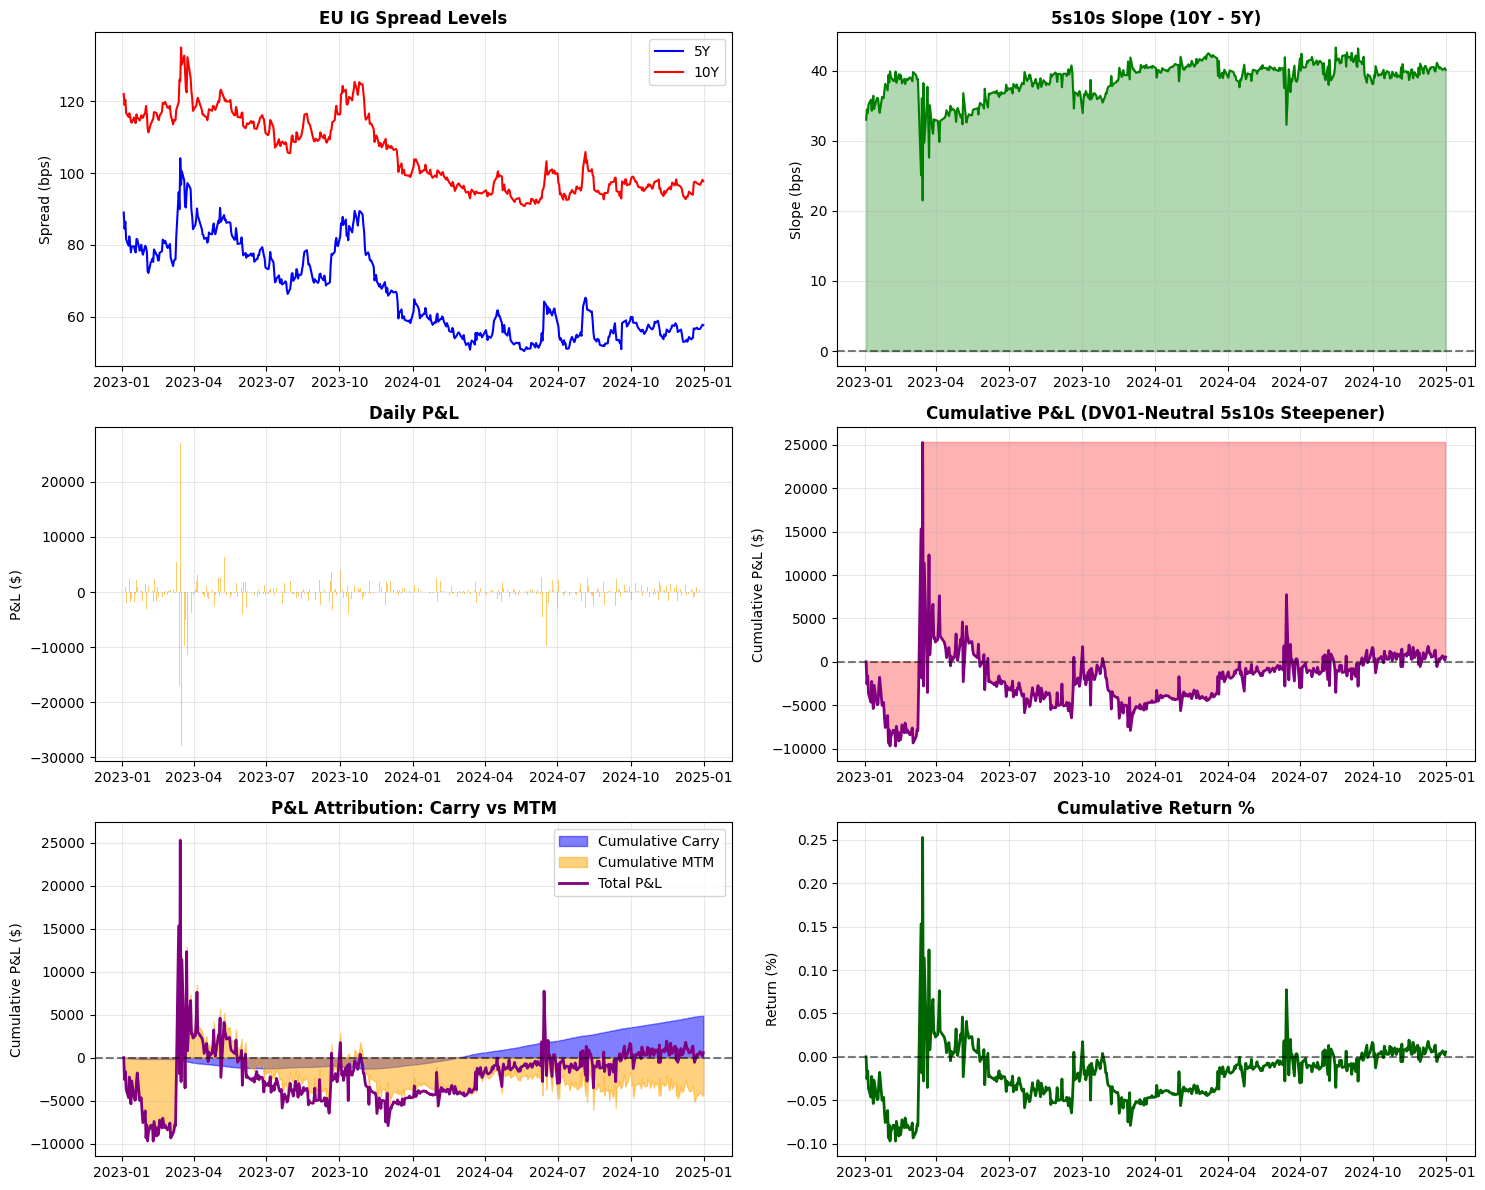


STRATEGY SUMMARY: DV01-Neutral 5s10s Steepener
Period: 2023-01-03 to 2024-12-31
Total P&L: $564
Total Return: 0.01%
Sharpe Ratio: 0.01
Max Drawdown: $-33,196
Current 5s10s Slope: 40.1 bps
Win Rate: 50.1%


In [4]:
# 5s10s DV01-Neutral Steepener P&L Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sys
sys.path.append('../src')
from models.database import CDSDatabase
from models.enums import create_simple_strategy, WeightType

def calculate_steepener_pnl(region: str = 'EU', 
                           market: str = 'IG',
                           base_notional: float = 10_000_000,
                           start_date: str = '2023-01-01',
                           end_date: str = '2024-12-31') -> pd.DataFrame:
    """
    Calculate P&L for a DV01-neutral 5s10s steepener using TRS approach
    """
    
    db_path = "C:/source/repos/psc/packages/psc_csa_tools/credit_macro/data/raw/cds_indices_raw.db"
    db = CDSDatabase(db_path)
    
    # Get data for both legs
    region_market = f"{region}_{market}"
    data_5y = db.query_historical_spreads(region_market, '5Y', start_date, end_date)
    data_10y = db.query_historical_spreads(region_market, '10Y', start_date, end_date)
    
    if data_5y.empty or data_10y.empty:
        print("No data available")
        db.close()
        return pd.DataFrame()
    
    # Calculate TRS for each leg
    # Copy the function here instead of importing
    def calculate_cds_total_return(spread_data, notional=10_000_000, recovery_rate=0.40):
        if spread_data.empty:
            return pd.DataFrame()
        
        df = spread_data.copy().sort_values('date').reset_index(drop=True)
        
        # Calculate approximate DV01 for 5Y CDS
        years_to_maturity = 5.0
        df['dv01_approx'] = (1 - recovery_rate) * df['spread_bps'] * years_to_maturity * notional / 10000
        
        # Calculate daily changes
        df['spread_change'] = df['spread_bps'].diff()
        df['daily_carry'] = df['spread_bps'] / 360
        
        # Mark-to-market P&L
        df['mtm_pnl_long'] = -df['spread_change'] * df['dv01_approx'] / 100
        df['mtm_pnl_short'] = df['spread_change'] * df['dv01_approx'] / 100
        
        # Roll adjustments
        df['is_roll_date'] = df['series_number'] != df['series_number'].shift(1)
        df['roll_cost'] = 0.0
        
        roll_dates = df[df['is_roll_date'] & (df.index > 0)]
        for idx in roll_dates.index:
            if idx > 0:
                spread_jump = df.loc[idx, 'spread_bps'] - df.loc[idx-1, 'spread_bps']
                transaction_cost = 0.1
                df.loc[idx, 'roll_cost'] = (transaction_cost + abs(spread_jump) * 0.1) * df.loc[idx, 'dv01_approx'] / 100
        
        # Total daily P&L
        df['long_daily_pnl'] = (df['daily_carry'] * notional / 10000) + df['mtm_pnl_long'] - df['roll_cost']
        df['short_daily_pnl'] = -(df['daily_carry'] * notional / 10000) + df['mtm_pnl_short'] - df['roll_cost']
        
        # Daily returns
        df['long_daily_return'] = df['long_daily_pnl'] / notional
        df['short_daily_return'] = df['short_daily_pnl'] / notional
        
        # Cumulative total return indices (starting at 100)
        df['long_tr'] = 100.0
        df['short_tr'] = 100.0
        
        for i in range(1, len(df)):
            df.loc[i, 'long_tr'] = df.loc[i-1, 'long_tr'] * (1 + df.loc[i, 'long_daily_return'])
            df.loc[i, 'short_tr'] = df.loc[i-1, 'short_tr'] * (1 + df.loc[i, 'short_daily_return'])
        
        return df
    
    trs_5y = calculate_cds_total_return(data_5y, notional=10_000_000)
    trs_10y = calculate_cds_total_return(data_10y, notional=10_000_000)
    
    # Merge TRS data
    merged = pd.merge(trs_5y[['date', 'long_tr', 'short_tr', 'spread_bps']], 
                     trs_10y[['date', 'long_tr', 'short_tr', 'spread_bps']], 
                     on='date', suffixes=('_5y', '_10y'))
    
    if merged.empty:
        db.close()
        return pd.DataFrame()
    
    # DV01-neutral sizing
    notional_5y = base_notional  # Sell 5Y
    notional_10y = base_notional * 0.667  # Buy 10Y (DV01 neutral)
    
    # NORMALIZE TRS TO 100 AT ENTRY POINT
    # Get initial values
    initial_5y_short = merged['short_tr_5y'].iloc[0]
    initial_10y_long = merged['long_tr_10y'].iloc[0]
    
    # Normalize both series to start at 100
    merged['norm_5y_short'] = (merged['short_tr_5y'] / initial_5y_short) * 100
    merged['norm_10y_long'] = (merged['long_tr_10y'] / initial_10y_long) * 100
    
    # Calculate strategy TRS
    # Sell 5Y (short TRS) with notional_5y
    # Buy 10Y (long TRS) with notional_10y
    weight_5y = notional_5y / base_notional
    weight_10y = notional_10y / base_notional
    
    # Strategy index starts at 100
    merged['strategy_tr'] = 100.0
    
    # Calculate weighted performance
    # Short 5Y: we use the short_tr performance
    # Long 10Y: we use the long_tr performance
    merged['5y_contribution'] = weight_5y * (merged['norm_5y_short'] / 100)
    merged['10y_contribution'] = weight_10y * (merged['norm_10y_long'] / 100)
    
    # Combined strategy performance
    merged['strategy_tr'] = 100 * (merged['5y_contribution'] + merged['10y_contribution']) / (weight_5y + weight_10y)
    
    # Calculate P&L from the strategy TRS
    merged['strategy_return'] = (merged['strategy_tr'] / 100) - 1
    merged['cumulative_pnl'] = merged['strategy_return'] * base_notional
    
    # Calculate daily P&L
    merged['daily_return'] = merged['strategy_tr'].pct_change()
    merged['daily_pnl'] = merged['daily_return'] * base_notional
    merged.loc[0, 'daily_pnl'] = 0  # First day is zero
    
    # Calculate slope
    merged['slope_5s10s'] = merged['spread_bps_10y'] - merged['spread_bps_5y']
    
    db.close()
    return merged

def visualize_steepener_strategy():
    """Create comprehensive visualization of steepener P&L"""
    
    # Calculate P&L for EU IG 5s10s
    pnl_data = calculate_steepener_pnl('EU', 'IG')
    
    if pnl_data.empty:
        print("No data to visualize")
        return
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 12))
    
    # 1. Spread levels
    ax1 = plt.subplot(3, 2, 1)
    ax1.plot(pnl_data['date'], pnl_data['spread_bps_5y'], label='5Y', color='blue', linewidth=1.5)
    ax1.plot(pnl_data['date'], pnl_data['spread_bps_10y'], label='10Y', color='red', linewidth=1.5)
    ax1.set_title('EU IG Spread Levels', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Spread (bps)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 5s10s Slope
    ax2 = plt.subplot(3, 2, 2)
    ax2.plot(pnl_data['date'], pnl_data['slope_5s10s'], color='green', linewidth=1.5)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.set_title('5s10s Slope (10Y - 5Y)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Slope (bps)')
    ax2.grid(True, alpha=0.3)
    
    # Add shading for steepening/flattening periods
    ax2.fill_between(pnl_data['date'], 0, pnl_data['slope_5s10s'], 
                     where=(pnl_data['slope_5s10s'] > 0), alpha=0.3, color='green', label='Steep')
    ax2.fill_between(pnl_data['date'], 0, pnl_data['slope_5s10s'], 
                     where=(pnl_data['slope_5s10s'] <= 0), alpha=0.3, color='red', label='Inverted')
    
    # 3. Daily P&L
    ax3 = plt.subplot(3, 2, 3)
    ax3.bar(pnl_data['date'], pnl_data['daily_pnl'], alpha=0.6, color='orange')
    ax3.set_title('Daily P&L', fontsize=12, fontweight='bold')
    ax3.set_ylabel('P&L ($)')
    ax3.grid(True, alpha=0.3)
    
    # 4. Cumulative P&L
    ax4 = plt.subplot(3, 2, 4)
    ax4.plot(pnl_data['date'], pnl_data['cumulative_pnl'], color='purple', linewidth=2)
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.set_title('Cumulative P&L (DV01-Neutral 5s10s Steepener)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Cumulative P&L ($)')
    ax4.grid(True, alpha=0.3)
    
    # Add drawdown shading
    running_max = pnl_data['cumulative_pnl'].cummax()
    drawdown = pnl_data['cumulative_pnl'] - running_max
    ax4.fill_between(pnl_data['date'], pnl_data['cumulative_pnl'], running_max,
                     where=(drawdown < 0), alpha=0.3, color='red')
    
    # 5. P&L Attribution - Cumulative Carry vs MTM
    ax5 = plt.subplot(3, 2, 5)
    
    # Define notionals (same as in calculate_steepener_pnl)
    base_notional = 10_000_000
    notional_5y = base_notional  # Sell 5Y
    notional_10y = base_notional * 0.667  # Buy 10Y (DV01 neutral)
    
    # Extract carry and MTM from the individual TRS legs
    # For 5Y short: we pay carry (negative), gain on spread widening
    # For 10Y long: we receive carry (positive), lose on spread widening
    
    # Approximate the components
    # Daily carry approximation
    pnl_data['carry_5y'] = -pnl_data['spread_bps_5y'] / 360 * notional_5y / 10000
    pnl_data['carry_10y'] = pnl_data['spread_bps_10y'] / 360 * notional_10y / 10000
    pnl_data['net_carry'] = pnl_data['carry_5y'] + pnl_data['carry_10y']
    
    # MTM = Total P&L minus carry
    pnl_data['net_mtm'] = pnl_data['daily_pnl'] - pnl_data['net_carry']
    
    # Cumulative components
    pnl_data['cumulative_carry'] = pnl_data['net_carry'].cumsum()
    pnl_data['cumulative_mtm'] = pnl_data['net_mtm'].cumsum()
    
    ax5.fill_between(pnl_data['date'], 0, pnl_data['cumulative_carry'], 
                     alpha=0.5, color='blue', label='Cumulative Carry')
    ax5.fill_between(pnl_data['date'], 0, pnl_data['cumulative_mtm'], 
                     alpha=0.5, color='orange', label='Cumulative MTM')
    ax5.plot(pnl_data['date'], pnl_data['cumulative_pnl'], 
            color='purple', linewidth=2, label='Total P&L')
    ax5.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax5.set_title('P&L Attribution: Carry vs MTM', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Cumulative P&L ($)')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Cumulative Return %
    ax6 = plt.subplot(3, 2, 6)
    ax6.plot(pnl_data['date'], pnl_data['strategy_return'] * 100, color='darkgreen', linewidth=2)
    ax6.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax6.set_title('Cumulative Return %', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Return (%)')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    total_pnl = pnl_data['cumulative_pnl'].iloc[-1]
    total_return = pnl_data['strategy_return'].iloc[-1] * 100
    sharpe = (pnl_data['daily_return'].mean() / pnl_data['daily_return'].std()) * np.sqrt(252) if pnl_data['daily_return'].std() > 0 else 0
    
    # Calculate drawdown properly
    running_max = pnl_data['cumulative_pnl'].cummax()
    drawdown = pnl_data['cumulative_pnl'] - running_max
    max_dd = drawdown.min()
    
    print("\n" + "="*50)
    print("STRATEGY SUMMARY: DV01-Neutral 5s10s Steepener")
    print("="*50)
    print(f"Period: {pnl_data['date'].min().strftime('%Y-%m-%d')} to {pnl_data['date'].max().strftime('%Y-%m-%d')}")
    print(f"Total P&L: ${total_pnl:,.0f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: ${max_dd:,.0f}")
    print(f"Current 5s10s Slope: {pnl_data['slope_5s10s'].iloc[-1]:.1f} bps")
    print(f"Win Rate: {(pnl_data['daily_pnl'] > 0).mean():.1%}")
    
    return pnl_data

# Run visualization
if __name__ == "__main__":
    results = visualize_steepener_strategy()

In [5]:
from models.trs import TRSDatabaseBuilder  # Quick verification test

from pathlib import Path

# 1. Check paths exist
raw_db = Path(r"C:\source\repos\psc\packages\psc_csa_tools\credit_macro\data\raw\cds_indices_raw.db")
trs_db = Path(r"C:\source\repos\psc\packages\psc_csa_tools\credit_macro\data\processed\cds_trs.db")

print(f"Raw DB exists: {raw_db.exists()} ({raw_db.stat().st_size/1024/1024:.1f} MB)")
print(f"TRS DB exists: {trs_db.exists()}")

# 2. Test the builder
builder = TRSDatabaseBuilder(str(raw_db), str(trs_db))
print("Builder initialized successfully")

# 3. If TRS database exists, test it
if trs_db.exists():
    results = builder.test_database()
    print(f"Tables: {results['tables']}, Records: {results['total_records']:,}")
else:
    print("TRS database needs to be built first")
    # builder.build_trs_database(start_date='2020-01-01', verbose=True)

Raw DB exists: True (4.1 MB)
TRS DB exists: True
Builder initialized successfully
Total TRS tables: 16

Missing tables: 8
  - trs_eu_subfin_3y
  - trs_eu_subfin_5y
  - trs_eu_subfin_7y
  - trs_eu_subfin_10y
  - trs_eu_senfin_3y
  - trs_eu_senfin_5y
  - trs_eu_senfin_7y
  - trs_eu_senfin_10y

Total records across all tables: 9,939

Data coverage sample:
  trs_eu_ig_3y: 687 records (2023-01-02 00:00:00 to 2025-09-16 00:00:00)
  trs_eu_ig_5y: 684 records (2023-01-03 00:00:00 to 2025-09-16 00:00:00)
  trs_eu_ig_7y: 560 records (2023-01-02 00:00:00 to 2025-09-15 00:00:00)
  trs_eu_ig_10y: 700 records (2023-01-02 00:00:00 to 2025-09-15 00:00:00)
  trs_eu_xo_3y: 697 records (2023-01-03 00:00:00 to 2025-09-15 00:00:00)
Tables: 16, Records: 9,939


In [6]:
import sqlite3
import pandas as pd

db_path = r"C:\source\repos\psc\packages\psc_csa_tools\credit_macro\data\processed\cds_trs.db"
conn = sqlite3.connect(db_path)

# Check what tables exist
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
print("Tables in database:")
print(tables)

# Check data in one table
test_data = pd.read_sql_query("SELECT * FROM trs_eu_ig_10y LIMIT 5", conn)
print("\nSample data from EU_IG_10Y:")
print(test_data)

conn.close()

Tables in database:
             name
0    trs_eu_ig_3y
1    trs_eu_ig_5y
2    trs_eu_ig_7y
3   trs_eu_ig_10y
4    trs_eu_xo_3y
5    trs_eu_xo_5y
6    trs_eu_xo_7y
7   trs_eu_xo_10y
8    trs_us_ig_3y
9    trs_us_ig_5y
10   trs_us_ig_7y
11  trs_us_ig_10y
12   trs_us_hy_3y
13   trs_us_hy_5y
14   trs_us_hy_7y
15  trs_us_hy_10y
16       metadata

Sample data from EU_IG_10Y:
                  date  spread_bps  series_number     long_tr    short_tr  \
0  2023-01-02 00:00:00     122.578             38  100.000000  100.000000   
1  2023-01-03 00:00:00     122.033             38  100.043295   99.956705   
2  2023-01-04 00:00:00     118.992             38  100.263808   99.736383   
3  2023-01-05 00:00:00     120.444             38  100.161955   99.837700   
4  2023-01-06 00:00:00     116.766             38  100.423300   99.577201   

       long_pnl     short_pnl  daily_return_long  daily_return_short  
0           NaN           NaN                NaN                 NaN  
1   4329.459656  -4329

In [7]:
# Update TRS Database with Latest Data
from models.trs import TRSDatabaseBuilder
from pathlib import Path
from datetime import datetime

# Define paths
raw_db_path = r"C:\source\repos\psc\packages\psc_csa_tools\credit_macro\data\raw\cds_indices_raw.db"
trs_db_path = r"C:\source\repos\psc\packages\psc_csa_tools\credit_macro\data\processed\cds_trs.db"

# Check if databases exist
raw_exists = Path(raw_db_path).exists()
trs_exists = Path(trs_db_path).exists()

print(f"Raw database exists: {raw_exists}")
print(f"TRS database exists: {trs_exists}")
print("-" * 60)

# Create builder
builder = TRSDatabaseBuilder(raw_db_path, trs_db_path)

if not trs_exists:
    # Build from scratch if TRS database doesn't exist
    print("TRS database doesn't exist. Building from scratch...")
    print("This may take a few minutes...")
    
    processed, failed = builder.build_trs_database(
        start_date='2020-01-01',  # Adjust this date based on your data availability
        verbose=True
    )
    
    print(f"\n{'='*60}")
    print(f"Initial build complete!")
    print(f"Processed: {len(processed)} series")
    print(f"Failed: {len(failed)} series")
    
else:
    # Update existing database with recent data
    print("Updating existing TRS database with recent data...")
    
    # First check current status
    test_results = builder.test_database()
    print(f"Current status: {test_results['tables']} tables, {test_results['total_records']:,} total records")
    print("-" * 60)
    
    # Update with last 30 days of data (adjust as needed)
    updated, failed_updates = builder.update_trs_database(
        days_back=30,  # Look back 30 days for any missing data
        verbose=True
    )
    
    print(f"\n{'='*60}")
    print(f"Update complete!")
    print(f"Updated: {updated} series")
    if failed_updates:
        print(f"Failed: {', '.join(failed_updates)}")

# Test retrieval to confirm it's working
print(f"\n{'='*60}")
print("Testing data retrieval...")

test_cases = [
    ('US_HY', '5Y'),
    ('EU_IG', '5Y'),
    ('EU_XO', '5Y')
]

for index_name, tenor in test_cases:
    data = builder.get_trs_data(index_name, tenor, '2024-01-01', '2024-12-31')
    if not data.empty:
        latest = data.iloc[-1]
        print(f"{index_name} {tenor}: {len(data)} records, Latest date: {latest['date'].date()}, "
              f"Long TR: {latest['long_tr']:.2f}, Short TR: {latest['short_tr']:.2f}")
    else:
        print(f"{index_name} {tenor}: No data for 2024")

print("\n✓ TRS database is ready for use!")

Raw database exists: True
TRS database exists: True
------------------------------------------------------------
Updating existing TRS database with recent data...
Total TRS tables: 16

Missing tables: 8
  - trs_eu_subfin_3y
  - trs_eu_subfin_5y
  - trs_eu_subfin_7y
  - trs_eu_subfin_10y
  - trs_eu_senfin_3y
  - trs_eu_senfin_5y
  - trs_eu_senfin_7y
  - trs_eu_senfin_10y

Total records across all tables: 9,939

Data coverage sample:
  trs_eu_ig_3y: 687 records (2023-01-02 00:00:00 to 2025-09-16 00:00:00)
  trs_eu_ig_5y: 684 records (2023-01-03 00:00:00 to 2025-09-16 00:00:00)
  trs_eu_ig_7y: 560 records (2023-01-02 00:00:00 to 2025-09-15 00:00:00)
  trs_eu_ig_10y: 700 records (2023-01-02 00:00:00 to 2025-09-15 00:00:00)
  trs_eu_xo_3y: 697 records (2023-01-03 00:00:00 to 2025-09-15 00:00:00)
Current status: 16 tables, 9,939 total records
------------------------------------------------------------
  EU_IG 3Y: Added 4 records
  EU_IG 5Y: Added 4 records
  EU_IG 7Y: Added 4 records
  EU_